# Clustering Techniques
Author: Sean Flannery [sflanner@purdue.edu](sflanner@purdue.edu)

Last Updated: June 15th, 2019

This notebook was developed with the intent of satisfying clustering needs for work with
Professor Daisuke Kihara [dkihara@purdue.edu](dkihara@purdue.edu).
### Description
This notebook takes the result of an embedding generated by a Doc2Vec model and applies distinct clustering techniques to it.

**Libraries Needed:** 
[pandas](https://pandas.pydata.org/pandas-docs/stable/install.html), 
[numpy](https://www.numpy.org), 
[tqdm](https://github.com/tqdm/tqdm), 
[scikit-learn](https://scikit-learn.org/stable/install.html),

**Reference:** This notebook relied heavily on information from the scikit-learn library's documentation [here](https://scikit-learn.org/stable/modules/clustering.html)

In [1]:
FILE_PREFIX = '' #Optional! 

In [2]:
# Standard imports
import random
random.seed(42)
import collections
import os
from multiprocessing import Pool
import pandas as pd
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
# Progress bar
from tqdm import tqdm_notebook as tqdm

import warnings
warnings.simplefilter(action='ignore')

In [4]:
db = pd.read_csv('preprocessed_data.csv')
db.head()

,year,article-link,local-path,title,abstract,authors,introduction,preprocessed_data
0,2019,https://doi.org/10.1093/nar/gky993,articles/2019/1-NAR.html,Database Resources of the BIG Data Center in 2019,The BIG Data Center at Beijing Institute of Ge...,['BIG Data Center Members'],The BIG Data Center (http://bigd.big.ac.cn) at...,big center beij institute genomic big chinese...
1,2019,https://doi.org/10.1093/nar/gky1124,articles/2019/2-NAR.html,The European Bioinformatics Institute in 2018:...,The European Bioinformatics Institute (https:/...,"['Charles E Cook', 'Rodrigo Lopez', 'Oana Stro...","A primary mission of EMBL-EBI is to collect, o...",european bioinformatic institute ebi archive ...
2,2019,https://doi.org/10.1093/nar/gky1069,articles/2019/3-NAR.html,Database resources of the National Center for ...,The National Center for Biotechnology Informat...,"['Eric W Sayers', 'Richa Agarwala', 'Evan E Bo...",The National Center for Biotechnology Informat...,national center biotechnology ncbi large suit...
3,2019,https://doi.org/10.1093/nar/gky843,articles/2019/4-NAR.html,AmtDB: a database of ancient human mitochondri...,Ancient mitochondrial DNA is used for tracing ...,"['Edvard Ehler', 'Jiří Novotný', 'Anna Juras',...",Ancient DNA (aDNA) is a genetic material obtai...,ancient mitochondrial dna trace human past de...
4,2019,https://doi.org/10.1093/nar/gky822,articles/2019/5-NAR.html,AnimalTFDB 3.0: a comprehensive resource for a...,The Animal Transcription Factor DataBase (Anim...,"['Hui Hu', 'Ya-Ru Miao', 'Long-Hao Jia', 'Qing...",Transcription factors (TFs) are special protei...,animal transcription factor animaltfdb aim co...


In [5]:
raw_data = np.load(FILE_PREFIX + 'doc_embeddings.npy')

## PCA

In [6]:
from sklearn.decomposition import PCA, KernelPCA, SparsePCA
from sklearn.preprocessing import scale

In [7]:
pca = PCA(n_components=3, 
#          svd_solver='randomized', 
#          iterated_power=1000,
         random_state=42)
scaleX = scale(raw_data)
reduced_data = pca.fit_transform(scaleX)

In [8]:
print('Explained Variance Ratios: ' + str(sum(pca.explained_variance_ratio_)))
print('Explained Variance Ratios: ' + str(pca.explained_variance_ratio_))

Explained Variance Ratios: 0.09905707123229006
Explained Variance Ratios: [0.04483057 0.02949884 0.02472766]


In [9]:
db['pca_feature1'] = [ent for ent in reduced_data[:,0]]
db['pca_feature2'] = [ent for ent in reduced_data[:,1]]
db['pca_feature3'] = [ent for ent in reduced_data[:,2]]

In [ ]:
variance = []
for i in tqdm(range(len(raw_data[0]) - 1)):
    variance.append(sum(PCA(n_components=i + 1, svd_solver='arpack').fit(scaleX).explained_variance_ratio_))

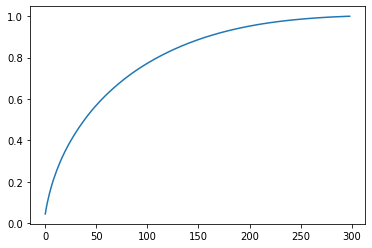

In [13]:
plt.plot(range(len(raw_data[0]) -1), variance)
plt.show()

## XMeans [Original paper](https://www.cs.cmu.edu/~dpelleg/download/xmeans.pdf)
K-Means based algorithm that seeks to address one of the major pitfalls of K-Means:
- **The Number of clusters `K` must be supplied by the user**

The below code was based on the fantastic work on the Open-Source [pyxmeans project](https://github.com/mynameisfiber/pyxmeans/blob/master/pyxmeans/xmeans.py) with the following modifications:
- used scikit-learn KMeans instead of their MiniBatch implementation
- initial centroids for any run of XMeans will be based on the `k` PCA components generated by the sklearn PCA library

In [14]:
from sklearn.metrics import euclidean_distances
from sklearn.cluster import KMeans
from collections import namedtuple
from sklearn.decomposition import PCA

import logging
logging.basicConfig(
    format='[%(asctime)s] %(levelname)s - %(funcName)s:%(lineno)d: %(message)s',
    level=logging.FATAL)

In [15]:
class XMeans(object):
    def __init__(self, kmin, kmax=None, init='k-means++', sample_percent=0.20,
                 minibatch_args=None, verbose=False):
        self.kmin = kmin
        self.kmax = kmax
        self.init = init
        self.sample_percent = sample_percent

        self.verbose = verbose
        if self.verbose:
            logging.getLogger().setLevel(logging.INFO)

        self._minibatch_args = minibatch_args or {}
        self.data_ = None
        self.cluster_centers_ = []

    def fit(self, data):
        data = self.data_ = np.asarray(data)
        k = self.kmin
        cluster_centers = self.init
        while self.kmax is None or k <= self.kmax:
            logging.info("Fitting with k=%d", k)
            
            self._model = self._fit(k, data, cluster_centers)

            centroid_distances = euclidean_distances(
                self._model.cluster_centers_, 
                self._model.cluster_centers_)
            centroid_distances += np.diag([np.Infinity] * k)
            centroids_range = centroid_distances.min(axis=-1)

            #print("K: " + str(k))
            cluster_centers = []
            
            for i, centroid in enumerate(self._model.cluster_centers_):
                logging.info("\tSplitting cluster %d / %d (k=%d)",
                    i+1,
                    len(self._model.cluster_centers_),
                    len(cluster_centers),
                )
                direction = np.random.random(centroid.shape)
                vector = direction * (centroids_range[i] /
                                      np.sqrt(direction.dot(direction)))

                new_point1 = centroid + vector
                new_point2 = centroid - vector

                logging.info("\t\tRunning secondary kmeans")
                model_index = (self._model.labels_ == i)
                if not np.any(model_index):
                    logging.info(
                        "Disregarding cluster since it has no citizens")
                    continue
                #print(np.asarray([new_point1, new_point2]).shape)
                points = data[model_index]
                if (len(points) < 2):
                    continue
                #print(points.shape)
                test_model = self._fit(2, points,
                                       np.asarray([new_point1, new_point2]))

                cluster1 = points[test_model.labels_ == 0]
                cluster2 = points[test_model.labels_ == 1]

                bic_parent = XMeans.bic([points], [centroid,])
                bic_child = XMeans.bic([cluster1, cluster2],
                                       test_model.cluster_centers_)
                logging.info("\t\tbic_parent = %f, bic_child = %f",
                             bic_parent, bic_child)
                if bic_child > bic_parent:
                    logging.info("\tUsing children")
                    cluster_centers.append(test_model.cluster_centers_[0])
                    cluster_centers.append(test_model.cluster_centers_[1])
                else:
                    logging.info("\tUsing parent")
                    cluster_centers.append(centroid)
            if k == len(cluster_centers):
                logging.info("Done")
                break
            k = len(cluster_centers)
        return self._fit(k, data, cluster_centers)

    @classmethod
    def bic(cls, clusters, centroids):
        num_points = sum(len(cluster) for cluster in clusters)
        num_dims = clusters[0][0].shape[0]

        log_likelihood = XMeans._loglikelihood(num_points, num_dims,
                                               clusters, centroids)
        num_params = XMeans._free_params(len(clusters), num_dims)

        return log_likelihood - num_params / 2.0 * np.log(num_points)

    @classmethod
    def _free_params(cls, num_clusters, num_dims):
        return num_clusters * (num_dims + 1)

    @classmethod
    def _loglikelihood(cls, num_points, num_dims, clusters, centroids):
        ll = 0
        for cluster in clusters:
            fRn = len(cluster)
            t1 = fRn * np.log(fRn)
            t2 = fRn * np.log(num_points)
            variance = max(
                XMeans._cluster_variance(num_points, clusters, centroids),
                np.nextafter(0, 1))
            t3 = ((fRn * num_dims) / 2.0) * np.log((2.0 * np.pi) * variance)
            t4 = num_dims * (fRn - 1.0) / 2.0
            ll += t1 - t2 - t3 - t4
        return ll

    @classmethod
    def _cluster_variance(cls, num_points, clusters, centroids):
        s = 0
        num_dims = clusters[0][0].shape[0]
        denom = float(num_points - len(centroids)) * num_dims
        for cluster, centroid in zip(clusters, centroids):
            distances = euclidean_distances(cluster, [centroid,])
            s += (distances*distances).sum()
        return s / denom


    def _fit(self, k, data, centroids=None):
        if centroids in ('k-means++', 'random'):
            init = centroids
        elif centroids in ('pca',):
            init = PCA(n_components=k, 
                       svd_solver='full',
                      random_state=42).fit(data).components_
        else:
            init = np.array(centroids, dtype=data.dtype, copy=True)
        n_samples = int(self.sample_percent * len(data))
        model = KMeans(
            n_clusters=k,
            init = init,
            n_init = 2000,# Decrease this to make it run faster
            n_jobs=-1,
            random_state=42
        ).fit(data)
        
        return model

In [16]:
from sklearn.preprocessing import scale

sample_percents = [ent / 100. for ent in list(range(10,91,10))]

results = []
TRIAL_NUM = 3
scaled_data = scale(raw_data)
for sample in tqdm(sample_percents):
    trials_sum = 0
    for trial in tqdm(list(range(TRIAL_NUM)), leave=False):
        xm = XMeans(kmin=2, 
            kmax=None, 
            init='pca', 
            sample_percent=sample).fit(scaled_data)
        trials_sum += len(xm.cluster_centers_)
    results.append(trials_sum/(TRIAL_NUM + 0.0))

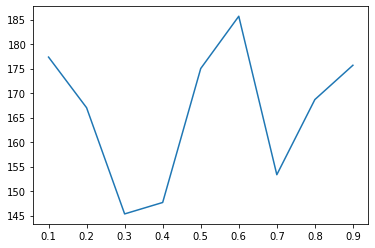

In [17]:
plt.plot(sample_percents, results)

Below we establish an estimated number of clusters based on the XMeans approach that we may use later.

In [22]:
estimated_n_clusters = round(sum(results)/len(results))
print("Average Number of Clusters Estimated from Experiments: " + str(estimated_n_clusters))

Average Number of Clusters Estimated from Experiments: 166


We take a typical run of XMeans to serves as our representative set for now. This may be improved later by analyzing silhouette scores among the different XMeans results.

In [19]:
xm = XMeans(kmin=2, 
            kmax=None, 
            init='pca', 
            sample_percent=0.20).fit(scaled_data)

In [20]:
print("Number of clusters used for x-means clustering: " + str(len(set(xm.labels_))))

Number of clusters used for x-means clustering: 185


In [21]:
db['xmeans_cluster'] = xm.labels_

## K-Means
**Parameters Needed** 
- Number of Clusters we Expect

**Scalability**
- Handles large number of samples
- Can handle medium number of clusters

**Usecase**
- General-purpose
- even cluster size
- flat geometry
- not too many clusters

**Geometry**
- Distances between points
    - Euclidean Distance
    - Cosine Distance

In [26]:
from sklearn.metrics import silhouette_score

In [24]:
scaleX = scale(raw_data)

In [49]:
silhouette_list = []
range_n_clusters = list(range(2, 301,5))
for n_clusters in tqdm(range_n_clusters):
    # Initialize the clusterer with n_clusters value and a random generator
    clusterer = KMeans(n_clusters=n_clusters, 
                        #init='k-means++',
                        init=PCA(n_components=n_clusters, 
                        svd_solver='full',
                        random_state=42).fit(scaled_data).components_, 
                        n_init=25,
                           random_state=42, n_jobs=-1)
    cluster_labels = clusterer.fit_predict(scaleX)
    cluster_centers = clusterer.cluster_centers_

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(scaleX, cluster_labels)
    silhouette_list.append(silhouette_avg)

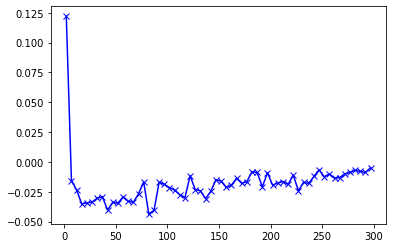

In [50]:
plt.plot(range_n_clusters, silhouette_list, 'bx-')

We may use the elbow method to find a good cluster size, however one does not appear to come naturally from the data, and we even see the silhouette score increase over time. 

In [51]:
kmeans_estimate = estimated_n_clusters

In [52]:
km = KMeans(n_clusters=kmeans_estimate, 
            init=PCA(n_components=estimated_n_clusters, 
                       svd_solver='full',
                      random_state=42).fit(scaled_data).components_, 
            n_init=1000,
            max_iter=20000,
            n_jobs=-1
           ).fit(scaled_data)

In [53]:
db['kmeans_cluster'] = km.labels_

In [54]:
db.to_csv(FILE_PREFIX + 'cluster_results.csv', index=False)

From here, continue onto the Vizualization Notebook! The other clustering techniques are in development.

## Hierarchical Clustering

## DBSCAN
**Parameters Needed** 
- neighborhood size

**Scalability**
- Handles large number of samples
- Can handle medium number of clusters

**Usecase**
- Uneven Cluster Size
- Non-flat geometry

**Geometry**
- Distances between nearest points

## Agglomerative Clustering

The AgglomerativeClustering object performs a hierarchical clustering using a bottom up approach: each observation starts in its own cluster, and clusters are successively merged together. The linkage criteria determines the metric used for the merge strategy:

**Parameters Needed** 
- number of clusters OR
- distance threshold
- linkage type
- distance

**Scalability**
- Handles large number of samples
- Can handle large number of clusters

**Usecase**
- Many clusters
- Possibly connectivity constraints
- non-Euclidean distances

**Geometry**
- Any pairwise distance

### Calculate Affinity Marix
**Input**
- `coordinates` of our data
- `k` (number of neighbors to consider)

[Source for code](https://towardsdatascience.com/spectral-graph-clustering-and-optimal-number-of-clusters-estimation-32704189afbe)

[Source for paper](https://papers.nips.cc/paper/2619-self-tuning-spectral-clustering.pdf)

In [ ]:
from scipy.spatial.distance import pdist, squareform

In [ ]:
def getAffinityMatrix(coordinates, k = 10):
    #calculate euclidean distance matrix
    dists = squareform(pdist(coordinates))
    
    # for each row, sort the distances ascendingly and take the index of the 
    # k-th position (nearest neighbor)
    knn_distances = np.sort(dists, axis=0)[k]
    knn_distances = knn_distances[np.newaxis].T
    
    # calculate sigma_i * sigma_j
    local_scale = knn_distances.dot(knn_distances.T)
    
    affinity_matrix = dists * dists
    affinity_matrix = -affinity_matrix / local_scale
    # divide square distances matrix by local scale
    affinity_matrix[np.where(np.isnan(affinity_matrix))] = 0.0
    # apply exponential
    affinity_matrix = np.exp(affinity_matrix)
    np.fill_diagonal(affinity_matrix, 0)
    return affinity_matrix

In [ ]:
A = getAffinityMatrix(X, k=10)

In [ ]:
A.shape

### Eigengap heuristic for finding the optimal number of clusters
Based on approach outlined in this [paper](http://www.kyb.mpg.de/fileadmin/user_upload/files/publications/attachments/Luxburg07_tutorial_4488%5B0%5D.pdf), which proposes an apporach based on **perturbation theory** and **spectral graph theory** to calculate the optimal number of clusters. 

Heuristic used is to find a value of `k` that maximizes the *Eigengap* (difference between consecutive eigenvalues).

**Input**
- `A` affinity matrix
- `plot` whether or not we wish to plot

In [ ]:
import scipy
from scipy.sparse import csgraph
from scipy.sparse.linalg import eigsh

In [ ]:
def eigenDecomposition(A, plot = True):
    # get normalized laplacian matrix from our affinity matrix
    L = csgraph.laplacian(A, normed=True)
    n_components = A.shape[0]
    
    # LM Parameter: Eigenvalues wiht largest magnitude (eigs, eigsh)
    # that is, largest eigenvalues in the euclidean norm of complex numbers
    eigenvalues, eigenvectors = eigsh(
                        L,
                        k=n_components,
                        which="LM",
                        sigma=1.0,
                        maxiter=100000#maxiter=5000
                        )
    
    # threshold is used to prevent unusually small clusters
    low = 0 # We expect at least n + 1 clusters to exist
    hi = 500# We expect no more than n - 1 clusters
    
    eigenvalues = eigenvalues[low:hi]
    
    if plot:
        plt.title('Largest eigen values of input matrix')
        plt.scatter(np.arange(len(eigenvalues)), eigenvalues)
        plt.grid()
        
    # Identify the optimal number of clusters as the index corresponding
    # to the larger gap between eigen values
    index_largest_gap = np.argmax(np.diff(eigenvalues))
    nb_clusters = index_largest_gap + 1 + low
    
    # Get the most optimal cluster sizes in descending order
    best_clusters = np.argsort(-np.diff(eigenvalues)) + low  + 1
    
    return nb_clusters, eigenvalues, eigenvectors, best_clusters

In [ ]:
nb_clusters, eigenvalues, eigenvectors, top_c = eigenDecomposition(A)

In [ ]:
N = 100
print("Top", str(N), "Cluster Sizes")
for i in range(0,min(len(top_c),N)):
    print(str(1 + i) + ":\t" + str(top_c[i]))

## Gaussian Mixture

## Visualizing Data

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

In [ ]:
X = StandardScaler().fit_transform(data)
from sklearn import preprocessing  # to normalise existing X
X = preprocessing.normalize(data)

In [ ]:
def silhouette_values(n_clusters):
    # Create a subplot with 1 row and 2 columns
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42, init='k-means++')
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    
    #silhouette_list.append(silhouette_avg)
    # Compute the silhouette scores for each sample
    #sample_silhouette_values = silhouette_samples(X, cluster_labels)
    return silhouette_avg

In [ ]:
#41 performed quite well
cluster_list = list(range(5,501,5)) #+ list(range(10,100, 5))

In [ ]:
with Pool(25) as p:
    silhouette_list = list(tqdm(p.imap(silhouette_values, cluster_list), total=len(cluster_list), leave=True))

In [ ]:
plt.plot(cluster_list, silhouette_list)

In [ ]:
from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

# NOTE TO SELF: We should be using cosine distance and not just euclidean
https://towardsdatascience.com/automatic-topic-clustering-using-doc2vec-e1cea88449c


In [ ]:
silhouette_list = []
range_n_clusters = cluster_list
for n_clusters in tqdm(range_n_clusters):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
 
    # Initialize the clusterer with n_clusters value and a random generator
    clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_jobs=-1, init='k-means++')
    cluster_labels = clusterer.fit_predict(X)
    cluster_centers = clusterer.cluster_centers_

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)

    #print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

    silhouette_list.append(silhouette_avg)
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    tmpPCA = PCA(n_components=2)
    reduced_data = tmpPCA.fit_transform(X)
    pca_clusterer = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)
    cluster_labels = clusterer.fit_predict(reduced_data)
    #pca_cluster_centers = PCA(n_components=2).fit_transform(cluster_centers)
    pca_cluster_centers = tmpPCA.transform(cluster_centers)
    
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # This is for the very end of the code
    DESIRED_CLUSTERS = 150
    if n_clusters == DESIRED_CLUSTERS:
        final_cluster_dict = dict() 
   
    # center
    centers = []
    
    for i in range(n_clusters):
        reduced_data_values = reduced_data[cluster_labels == i]
        size_cluster_i = len(reduced_data_values)
        color = [cm.nipy_spectral(float(i) / n_clusters)]
        ax2.scatter(reduced_data_values[:, 0], reduced_data_values[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=color, edgecolor='k')
        
        centers.append([sum(reduced_data_values[:,0])/float(size_cluster_i), 
                        sum(reduced_data_values[:,1])/float(size_cluster_i)])
        # This is for the very end of the code 
        if n_clusters == DESIRED_CLUSTERS:
            final_cluster_dict[i] = {'cluster':[],'x':[], 'y':[]}
            final_cluster_dict[i]['cluster'] = i
            final_cluster_dict[i]['x'] = sum(reduced_data_values[:,0])/float(size_cluster_i)
            final_cluster_dict[i]['y'] = sum(reduced_data_values[:,1])/float(size_cluster_i)
    centers = np.array(centers)
    
    # Labeling the clusters
    #centers = clusterer.cluster_centers_
    #centers = pca_cluster_centers
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
plt.show()